Special thanks to following author whom I referenced from in creating this notebook:

https://jovian.ml/aakashns/03-logistic-regression

# Image Classification using Logistic Regression in PyTorch


This notebook will give you an idea of how to predict numbers from images using Pytorch. We will build a simple Logistic Regression Neural Network to identify the digits, and you'll see at the end that we can get an accuracy of ~86.5%!

##The Data

We'll use the famous [*MNIST Handwritten Digits Database*] as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9), along with labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

## Exploring the Data

Import `torch` and `torchvision`. 

`torchvision` contains some utilities for working with image data. It also contains helper classes to automatically download and import popular datasets like MNIST.

In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


When this statement is executed for the first time, it downloads the data to the `data/` directory next to the notebook and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded.

In [3]:
# Check the size of the dataset
print(len(dataset))

60000


The dataset has 60,000 images which can be used to train the model. There is also an additonal test set of 10,000 images which can be created by passing `train=False` to the `MNIST` class.

In [4]:
test_dataset = MNIST(root='data/', train=False)
print(len(test_dataset))

10000


Looking at a sample element from the training dataset:

In [ ]:
print(dataset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F87B3B1A588>, 5)


It's a tuple, consisting of a 28x28 image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Along with importing `matplotlib`, a special statement `%matplotlib inline` is added to indicate to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called IPython magic commands, and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


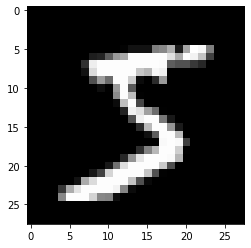

In [6]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


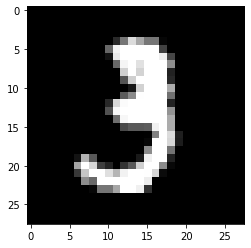

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

While it may be useful to visualise these images, there is just one problem: Pytorch does not recognise these raw images.

We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [7]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. `torchvision.transforms` contains many such predefined functions, and we'll use the `ToTensor` transform to convert images into PyTorch tensors.

`torchvision.transforms` also contains many other [data augmentation techniques](https://pytorch.org/docs/stable/torchvision/transforms.html) that could be used to augment the images in the dataset before training on a model. 

In [8]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [9]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension is used to keep track of the color channels. 

Since images in the MNIST dataset are grayscale, there's just one channel. Most other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB), so their more common dimensions would be `[3, HEIGHT, WIDTH]`. 

Our MNIST dataset are greyscale values, hence, the first dimension = 1. Let's look at some sample values inside the tensor:

In [ ]:
# prints only 10th to 15th pixel of image

print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values in between different shades of grey. 

We plot the tensor as an image using `plt.imshow`.

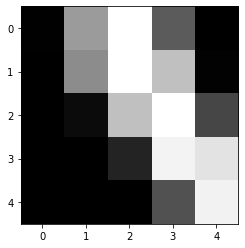

In [ ]:
# Plot the image by passing in the 28x28 matrix, prints only pixel value from 10 to 15th position
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a colour map (`cmap=gray`) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, check for potential overfitting/underfitting and adjust hyperparameters (e.g. learning rate) accordingly.
3. **Test set** - used to compare different models after training and to see how accurate model is on dataset that it hasn't seen.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. We set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

**Why random split?**

It's important to choose a random sample for creating a validation set, because training data is often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 10% validation set simply by selecting the last 10% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. The trained model would not be that good as it has not seen images of 8s and 9s.

Below is a code snippet on how to split dataset:


In [10]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

We can now created data loaders to help us load the data in batches. We'll use a batch size of 128.

We split dataset into batches because training on batches generally requires less memory, and also allows network to train faster with these mini-batches.

For more information on batch size, refer to this [forum](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network#:~:text=Advantages%20of%20using%20a%20batch,dataset%20in%20your%20machine's%20memory).


In [11]:
from torch.utils.data import DataLoader

batch_size = 128

# train_loader and val_loader breaks dataset into batches
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Visualise what train_loader and val_loader contain.

In [12]:
# See first batch in train_loader
for batch in train_loader:
    print(batch)
    break

# The same can be done for val_loader, try it out and see for yourself!

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

We set `shuffle=True` for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps generalize & speed up the training process. There is no need to shuffle images for validation dataloader since the it is used only for evaluating the model.

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* We can use `nn.Linear` to create the model.

* `nn.Linear` expects the each training example to be a vector, each `1x28x28` image tensor needs to be **flattened** out into a vector of size 784 (`28*28`), before being passed into the model. 

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

The `nn.Linear` model instantiates the weights and biases randomly, and applies a linear transformation to the incoming data: `y = x*W^T + b`.

Can find out more at this [forum](https://stackoverflow.com/questions/54916135/what-is-the-class-definition-of-nn-linear-in-pytorch#:~:text=Linear(784%2C%20256)).

In [20]:
import torch.nn as nn

# vector of size 784
input_size = 28*28
num_classes = 10

# Instantiate logistic regression model's weights and biases
model = nn.Linear(input_size, num_classes)

Taking a look at the weights and biases:

In [ ]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0184,  0.0288, -0.0148,  ...,  0.0276, -0.0142,  0.0039],
        [-0.0132, -0.0310,  0.0273,  ...,  0.0143,  0.0149, -0.0121],
        [ 0.0215,  0.0012, -0.0244,  ..., -0.0176, -0.0190, -0.0278],
        ...,
        [ 0.0292,  0.0291, -0.0199,  ...,  0.0179, -0.0003, -0.0214],
        [-0.0215, -0.0122,  0.0030,  ...,  0.0302,  0.0221,  0.0064],
        [ 0.0004,  0.0164,  0.0121,  ..., -0.0249,  0.0037, -0.0069]],
       requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0189,  0.0322,  0.0231, -0.0350,  0.0208,  0.0125,  0.0315,  0.0336,
         0.0208,  0.0093], requires_grad=True)

We see that there are a total of (784*10) + 10 = 7850 parameters here. 

Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset, and pass them into our model.

In [ ]:
for images, labels in train_loader:
    print(labels)
    # images = images.view(images.shape[0], -1) --> Fixes error
    print(images.shape)
    outputs = model(images)
    break

tensor([6, 1, 8, 6, 2, 1, 6, 0, 5, 4, 4, 3, 7, 3, 9, 7, 6, 4, 9, 7, 0, 4, 9, 6,
        6, 6, 3, 8, 9, 9, 4, 1, 7, 7, 0, 2, 1, 0, 1, 2, 5, 3, 8, 1, 2, 2, 4, 6,
        9, 7, 9, 5, 6, 2, 6, 7, 5, 9, 8, 4, 8, 5, 3, 8, 8, 5, 3, 1, 2, 3, 7, 0,
        3, 6, 0, 0, 9, 6, 1, 9, 1, 0, 6, 7, 5, 9, 4, 0, 7, 8, 1, 4, 9, 0, 8, 8,
        1, 9, 6, 6, 9, 3, 2, 7, 1, 5, 4, 4, 7, 1, 5, 1, 7, 4, 4, 9, 5, 9, 7, 5,
        6, 4, 9, 1, 3, 6, 1, 6])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

This leads to an error, because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out. 

We'll use the `.reshape` or `.view` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.

# Creating the Custom Model Class

We create a custom model class using [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

The code below is the base class for all neural network modules.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784) # Flattens the tensor from 28*28 to 784
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into `self.linear`.

`xb.reshape(-1, 784)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions, where the length along the 2nd dimension is 28\*28 (i.e. 784). One argument to `.reshape` can be set to `-1` (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

**Note:** Model no longer has `.weight` and `.bias` attributes (they are now inside the `.linear` attribute), but it does have a `.parameters` method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer later on.

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0041, -0.0250,  0.0012,  ...,  0.0235,  0.0245, -0.0227],
         [-0.0150,  0.0176,  0.0019,  ...,  0.0306,  0.0141,  0.0074],
         [ 0.0070, -0.0125,  0.0290,  ..., -0.0093,  0.0060,  0.0062],
         ...,
         [ 0.0030, -0.0234,  0.0200,  ...,  0.0012,  0.0309, -0.0218],
         [-0.0052,  0.0114, -0.0299,  ...,  0.0166, -0.0152,  0.0202],
         [ 0.0188,  0.0065, -0.0278,  ..., -0.0211,  0.0188,  0.0286]],
        requires_grad=True), Parameter containing:
 tensor([-0.0183,  0.0124,  0.0284, -0.0210, -0.0104,  0.0308, -0.0155, -0.0086,
          0.0115, -0.0061], requires_grad=True)]

As seen from above, the weights have a shape of (10,784), while the bias has a shape of (1,10).

Our new custom model can be used in the exact same way as before. Let's see if it works.

In [ ]:
# Loops through only one batch and stops
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)

# See first 2 outputs from batch
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1317,  0.0140, -0.1015, -0.3526, -0.0773, -0.1436, -0.1905,  0.0612,
          0.0586,  0.0943],
        [ 0.2194,  0.2517,  0.1710, -0.4346,  0.0415,  0.0216, -0.1147, -0.1441,
          0.0633, -0.0114]])


For each of the 128 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities, but for that the elements of each output row must lie between 0 to 1 and add up to 1, which is clearly not the case here. (i.e. there are negative values in the sample outputs)

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First we replace each element `yi` in an output row by `e^yi`, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1. 

We'll use the implementation that's provided within PyTorch, because it works well with multidimensional tensors (a list of output rows in our case).

In [15]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package, and requires us to specify a dimension along which the softmax must be applied.

In [ ]:
# Apply softmax for each output row (each sample image) --> Refer to top output.shape to see
probs = F.softmax(outputs, dim=1)

# Original outputs
print('Sample outputs(before softmax) :\n', outputs[:2].data)
print("")

# Look at sample probabilities
print("Sample probabilities(after softmax):\n", probs[:2].data)

# Add up the probabilities of an output row (sanity check)
print("Sum: ", torch.sum(probs[0]).item())

Sample outputs(before softmax) :
 tensor([[ 0.1317,  0.0140, -0.1015, -0.3526, -0.0773, -0.1436, -0.1905,  0.0612,
          0.0586,  0.0943],
        [ 0.2194,  0.2517,  0.1710, -0.4346,  0.0415,  0.0216, -0.1147, -0.1441,
          0.0633, -0.0114]])

Sample probabilities(after softmax):
 tensor([[0.1188, 0.1056, 0.0941, 0.0732, 0.0964, 0.0902, 0.0861, 0.1107, 0.1104,
         0.1144],
        [0.1216, 0.1256, 0.1159, 0.0632, 0.1018, 0.0998, 0.0871, 0.0845, 0.1040,
         0.0965]])
Sum:  1.0000001192092896


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using `torch.max`, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 1, 9, 2, 8, 8, 4, 2, 0, 1, 0, 2, 4, 2, 2, 8, 8, 8, 2, 2, 2, 8, 8, 8,
        2, 4, 2, 4, 8, 8, 8, 2, 2, 2, 2, 2, 9, 2, 2, 2, 8, 0, 8, 2, 8, 2, 2, 8,
        4, 8, 2, 2, 8, 2, 0, 4, 9, 0, 1, 9, 2, 2, 9, 2, 4, 0, 2, 2, 8, 1, 1, 2,
        8, 2, 2, 2, 2, 8, 8, 2, 4, 7, 8, 2, 2, 1, 2, 2, 2, 8, 2, 2, 8, 8, 2, 4,
        9, 8, 2, 8, 2, 2, 0, 2, 8, 4, 2, 8, 4, 8, 8, 1, 8, 0, 0, 2, 2, 1, 2, 2,
        2, 2, 1, 7, 8, 1, 2, 2])
tensor([0.1188, 0.1256, 0.1261, 0.1248, 0.1250, 0.1132, 0.1401, 0.1236, 0.1255,
        0.1200, 0.1248, 0.1399, 0.1324, 0.1400, 0.1256, 0.1382, 0.1517, 0.1269,
        0.1146, 0.1161, 0.1307, 0.1271, 0.1525, 0.1496, 0.1437, 0.1249, 0.1565,
        0.1389, 0.1211, 0.1293, 0.1214, 0.1342, 0.1235, 0.1513, 0.1232, 0.1359,
        0.1229, 0.1220, 0.1357, 0.1370, 0.1290, 0.1327, 0.1508, 0.1576, 0.1430,
        0.1386, 0.1271, 0.1260, 0.1253, 0.1446, 0.1310, 0.1387, 0.1368, 0.1203,
        0.1365, 0.1187, 0.1248, 0.1359, 0.1333, 0.1350, 0.1096, 0.1211, 0.1315,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [ ]:
labels

tensor([0, 2, 2, 7, 0, 7, 3, 2, 0, 7, 4, 3, 3, 6, 7, 7, 5, 9, 4, 3, 6, 9, 8, 0,
        8, 3, 4, 0, 0, 1, 0, 4, 8, 1, 1, 6, 2, 9, 1, 6, 2, 8, 8, 8, 0, 7, 5, 7,
        4, 3, 6, 9, 0, 1, 7, 4, 4, 8, 9, 0, 7, 6, 8, 3, 5, 7, 6, 8, 0, 6, 7, 3,
        0, 6, 8, 9, 2, 8, 2, 4, 1, 9, 3, 3, 8, 7, 2, 6, 1, 8, 1, 6, 5, 1, 4, 3,
        2, 1, 8, 8, 8, 5, 9, 9, 2, 0, 8, 0, 4, 8, 2, 7, 4, 1, 8, 9, 1, 7, 2, 4,
        2, 4, 7, 3, 5, 4, 1, 7])

Clearly, the predicted and the actual labels are completely different. Obviously, that's because we have started with randomly initialized weights and biases. We need to train the model i.e. adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

We need to find a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

In [ ]:
# No. of labels that were accurately printed out
labels == preds

tensor([ True, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False, False, False,  True, False,
         True, False, False, False, False, False, False, False])

In [ ]:
# Get accuracy of labels
print(torch.sum(labels == preds).item() / len(labels))

0.125


In [13]:
# Combine into a single function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The `==` performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy. 

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because `e^x` is an increasing function i.e. if `y1 > y2`, then `e^y1 > e^y2` and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. 

What do you expect the accuracy of the model to be this time round?

In [ ]:
accuracy(outputs, labels)

tensor(0.1250)

While the accuracy is a great way for evaluating the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases. They are simply functions that pick out the index with the highest probabilities.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. (i.e. gradient descent)

Due to these reasons, accuracy is a great **evaluation metric** for classification, but not a good loss function. A commonly used loss function for classification problems is the **cross entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function. 

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [ ]:
x = 0.001 #Play with this value
x2 = 0.9

predicted = [0.0618, 0.1140, x, 0.1454, 0.0868, 0.0906, 0.1027, 0.1501, 0.0932,
         0.0701]
actual= [0, 0 , 1, 0, 0, 0, 0, 0, 0, 0]

import math

# Higher probabilities mean the loss function is lower
print(-math.log(x))
print(-math.log(x2))

6.907755278982137
0.10536051565782628


Looking at values above, set probability of `x = 0.001` and `x2 = 0.9`. Taking the log of x2 will result in a lower value, which makes the log function result suitable to use as a loss function.

This sets the loss function:

In [16]:
loss_fn = F.cross_entropy

In [ ]:
print("Outputs:")
print(outputs)
print("Labels:")
print(labels)

Outputs:
tensor([[ 0.1317,  0.0140, -0.1015,  ...,  0.0612,  0.0586,  0.0943],
        [ 0.2194,  0.2517,  0.1710,  ..., -0.1441,  0.0633, -0.0114],
        [ 0.0769,  0.1012,  0.0922,  ..., -0.1774, -0.0214,  0.2594],
        ...,
        [ 0.0265,  0.1994,  0.1555,  ...,  0.0987,  0.1325,  0.0487],
        [ 0.2337,  0.0538,  0.2796,  ..., -0.2723,  0.1977,  0.2321],
        [ 0.1569,  0.0987,  0.2035,  ..., -0.2481, -0.0065,  0.0209]],
       grad_fn=<AddmmBackward>)
Labels:
tensor([0, 2, 2, 7, 0, 7, 3, 2, 0, 7, 4, 3, 3, 6, 7, 7, 5, 9, 4, 3, 6, 9, 8, 0,
        8, 3, 4, 0, 0, 1, 0, 4, 8, 1, 1, 6, 2, 9, 1, 6, 2, 8, 8, 8, 0, 7, 5, 7,
        4, 3, 6, 9, 0, 1, 7, 4, 4, 8, 9, 0, 7, 6, 8, 3, 5, 7, 6, 8, 0, 6, 7, 3,
        0, 6, 8, 9, 2, 8, 2, 4, 1, 9, 3, 3, 8, 7, 2, 6, 1, 8, 1, 6, 5, 1, 4, 3,
        2, 1, 8, 8, 8, 5, 9, 9, 2, 0, 8, 0, 4, 8, 2, 7, 4, 1, 8, 9, 1, 7, 2, 4,
        2, 4, 7, 3, 5, 4, 1, 7])


In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3019, grad_fn=<NllLossBackward>)


Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. `2.23` is look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. *Lower the loss, better the model.*

## Optimizer

We are going to use the `optim.SGD` optimizer to update the weights and biases during training, with a learning rate which will be defined later within the fit function.

Configurations like batch size, learning rate etc. need to be picked in advance while training machine learning models, and are called hyperparameters. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. You can try out different learning rates and see how it affects the training process.

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model.

Note that the optimizer we will use is defined later.

The training process consists of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific to the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

Let's try impelmenting the problem-specific parts within our `MnistModel` class:

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        print(out.shape, labels.shape)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Now we'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will peform the entire training process.

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Define opt_function to be SGD
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    # Define optimizer
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase (Pseudo code above)
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() # Backward propagation (Computes gradient of loss)
            optimizer.step() # Gradient Descent (Updates all weights and biases in model)
            optimizer.zero_grad() # Clears old gradients for the next loss.backward call
        # Validation phase (Pseudo code above)
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

The `fit` function records the validation loss and metric from each epoch and returns a history of the training process. This is useful for debugging & visualizing the training process. Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [ ]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.09256329387426376, 'val_loss': 2.3347525596618652}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly). 

We are now ready to train the model. Let's train for 5 epochs and look at the results.

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

With just 5 epochs of training, our model has reached an accuracy of about 80% on the validation set. Let's see if we can improve that by training for a few more epochs.

In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1325, val_acc: 0.8022
Epoch [1], val_loss: 1.0583, val_acc: 0.8100
Epoch [2], val_loss: 0.9976, val_acc: 0.8176
Epoch [3], val_loss: 0.9471, val_acc: 0.8226
Epoch [4], val_loss: 0.9045, val_acc: 0.8258


In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8680, val_acc: 0.8306
Epoch [1], val_loss: 0.8364, val_acc: 0.8341
Epoch [2], val_loss: 0.8087, val_acc: 0.8368
Epoch [3], val_loss: 0.7843, val_acc: 0.8392
Epoch [4], val_loss: 0.7626, val_acc: 0.8412


In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7431, val_acc: 0.8435
Epoch [1], val_loss: 0.7255, val_acc: 0.8447
Epoch [2], val_loss: 0.7095, val_acc: 0.8482
Epoch [3], val_loss: 0.6950, val_acc: 0.8501
Epoch [4], val_loss: 0.6817, val_acc: 0.8514


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. This is easier to see using a line graph.

In [ ]:
# See result and history variables
print(result0)
print(history1)
print(history2)
print(history3)
print(history4)

{'val_loss': 2.3347525596618652, 'val_acc': 0.09256329387426376}
[{'val_loss': 1.9669532775878906, 'val_acc': 0.6066060066223145}, {'val_loss': 1.697705864906311, 'val_acc': 0.7087618708610535}, {'val_loss': 1.4956480264663696, 'val_acc': 0.7471321225166321}, {'val_loss': 1.3426827192306519, 'val_acc': 0.7734375}, {'val_loss': 1.2249948978424072, 'val_acc': 0.7920292615890503}]
[{'val_loss': 1.1324853897094727, 'val_acc': 0.8022152185440063}, {'val_loss': 1.0582644939422607, 'val_acc': 0.8100277185440063}, {'val_loss': 0.9975762963294983, 'val_acc': 0.8176423907279968}, {'val_loss': 0.9471421241760254, 'val_acc': 0.8225870132446289}, {'val_loss': 0.9045060276985168, 'val_acc': 0.8257516026496887}]
[{'val_loss': 0.8679839372634888, 'val_acc': 0.8305972814559937}, {'val_loss': 0.8363796472549438, 'val_acc': 0.8340585231781006}, {'val_loss': 0.8087170720100403, 'val_acc': 0.8368275165557861}, {'val_loss': 0.7842980027198792, 'val_acc': 0.8392009735107422}, {'val_loss': 0.7625567317008972,

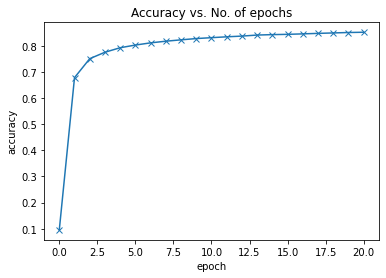

In [ ]:
# Replace these values with your results
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. It's possible that the model's paramaters are "bouncing" around the optimal set of parameters that have the lowest loss. 

Try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

There may be other better models out there involving things like convolutional networks which we will get into later on.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10,000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

Shape: torch.Size([1, 28, 28])
Label: 7


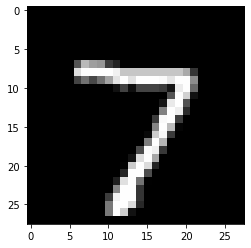

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
# Unsqueeze adds another dimension to the tensor, so img becomes a batch of one image
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


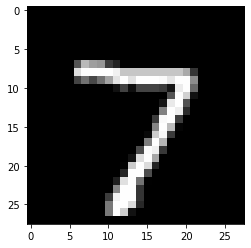

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


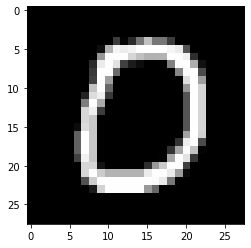

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


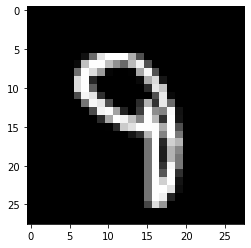

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

The following image is an instant where the predicted class is different from its label.

Label: 2 , Predicted: 8


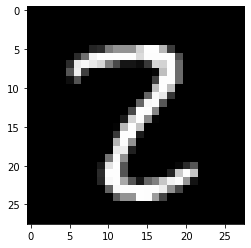

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8622070550918579, 'val_loss': 0.6392372250556946}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set.

## Extras: Saving and loading the model

It would be a good idea to save our model since we've trained it for a long time and achieved reasonable accuracy. Using larger datasets and running more epochs could lead to longer training times, sometimes even up to days. Therefore, it is important that we can save the model for future use and avoid retraining.

**When saving the model, we are actually saving the parameters (weights and bias matrices) to a file.**

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [ ]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0340, -0.0343, -0.0326,  ..., -0.0117,  0.0193, -0.0325],
                      [ 0.0190,  0.0165, -0.0352,  ..., -0.0333,  0.0079,  0.0047],
                      [-0.0232, -0.0181, -0.0190,  ..., -0.0034, -0.0288,  0.0015],
                      ...,
                      [-0.0289, -0.0074, -0.0120,  ...,  0.0272,  0.0035,  0.0215],
                      [ 0.0334, -0.0243,  0.0121,  ...,  0.0342, -0.0335, -0.0303],
                      [ 0.0277, -0.0229, -0.0316,  ..., -0.0086,  0.0267,  0.0145]])),
             ('linear.bias',
              tensor([-0.0379,  0.1232, -0.0117, -0.0179, -0.0009,  0.0137, -0.0091,  0.0544,
                      -0.1006,  0.0053]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [ ]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0340, -0.0343, -0.0326,  ..., -0.0117,  0.0193, -0.0325],
                      [ 0.0190,  0.0165, -0.0352,  ..., -0.0333,  0.0079,  0.0047],
                      [-0.0232, -0.0181, -0.0190,  ..., -0.0034, -0.0288,  0.0015],
                      ...,
                      [-0.0289, -0.0074, -0.0120,  ...,  0.0272,  0.0035,  0.0215],
                      [ 0.0334, -0.0243,  0.0121,  ...,  0.0342, -0.0335, -0.0303],
                      [ 0.0277, -0.0229, -0.0316,  ..., -0.0086,  0.0267,  0.0145]])),
             ('linear.bias',
              tensor([-0.0379,  0.1232, -0.0117, -0.0179, -0.0009,  0.0137, -0.0091,  0.0544,
                      -0.1006,  0.0053]))])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.8622070550918579, 'val_loss': 0.6392372250556946}

## Summary and Further Reading

We've created a fairly sophisticated training and evaluation pipeline in this notebook. Here's a list of the topics we've covered:

* Working with images in PyTorch (using MNIST dataset)
* Splitting and loading dataset into training, validation and test sets
* Creating PyTorch models with custom logic by extending the `nn.Module` class
* Interpreting model ouputs as probabilities using softmax, and picking predicted labels
* Picking a good evaluation metric (accuracy) and loss function (cross entropy) for classification problems
* Setting up a training loop that also evaluates the model using the validation set
* Testing the model manually on randomly picked examples 
* Saving and loading model checkpoints to avoid retraining from scratch

You can experiment with these few ideas to further your learning:

* Try changing the learning rate and see if you can achieve the same accuracy in fewer epochs.

* Try changing the batch size. What happens if you use too high a batch size, or too low?

* Modify the `fit` function to also track the overall loss and accuracy on the training set, and see how it compares with the validation loss/accuracy. Can you explain why it's lower/higher?

* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html), or maybe even your own dataset?


Some references for further reading:
* For a more mathematical treatment, see the popular [Machine Learning](https://www.coursera.org/lecture/machine-learning/classification-wlPeP) course on Coursera.

* The training loop defined in this notebook was inspired from [FastAI development notebooks](https://github.com/fastai/fastai_docs/blob/master/dev_nb/001a_nn_basics.ipynb) which contains other useful stuff.